In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import read_data as rd  # Importing the read_data.py module
from scipy.fft import fft
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

2024-06-05 10:03:00.160733: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 10:03:00.737314: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Function to normalize the data using min-max scaling
def normalize_data(data):
    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    normalized = (data - min_val) / (max_val - min_val)
    return normalized

In [3]:
# Load data
dataset_dir = '/home/ecappiell/datasets/full'
data_arrays, labels, class_ids = rd.process_mafaulda_data(dataset_dir)

In [4]:
# Original sampling rate (in Hz)
original_sampling_rate = 50 * 10**3  # 50 kHz

# Target sampling rate (in Hz)
target_sampling_rate = 1 * 10**3  # 1 kHz

# Downsample the data
downsampled_data = rd.downsample_data(data_arrays, original_sampling_rate, target_sampling_rate)

In [5]:
# Normalize the downsampled data
normalized_data = np.array([normalize_data(signal) for signal in downsampled_data])

In [55]:
def extract_fft_features(signal, fs, max_frequency=3000):
    N = len(signal)
    T = 1.0 / fs
    yf = fft(signal)
    xf = np.fft.fftfreq(N, T)[:N//2]
    yf = 2.0/N * np.abs(yf[:N//2])
    
    # Find the index corresponding to the maximum frequency
    max_index = int(max_frequency * N / fs)
    
    fft_features = yf[:max_index]
    return fft_features

In [56]:
# Extract FFT features for each signal up to 500 Hz
X = []
for signal in normalized_data:
    fft_features = np.array([extract_fft_features(signal[:, i], target_sampling_rate*5) for i in range(8)])
    X.append(fft_features)
X = np.array(X)

In [57]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, class_ids, test_size=0.2, random_state=37)

In [58]:
def create_model(input_shape, num_classes):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [59]:
input_shape = X_train.shape[1:]
num_classes = len(np.unique(class_ids))
model = create_model(input_shape, num_classes)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [60]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.2759 - loss: 1.7184 - val_accuracy: 0.2981 - val_loss: 1.5664
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3110 - loss: 1.5502 - val_accuracy: 0.3429 - val_loss: 1.4153
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4195 - loss: 1.3759 - val_accuracy: 0.4744 - val_loss: 1.2154
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5183 - loss: 1.1593 - val_accuracy: 0.5385 - val_loss: 1.0821
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5971 - loss: 0.9591 - val_accuracy: 0.5737 - val_loss: 0.9640
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6750 - loss: 0.8116 - val_accuracy: 0.6955 - val_loss: 0.8296
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7855 - loss: 0.6495 - val_accuracy: 0.7179 - val_loss: 0.7053
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8198 - loss: 0.5209 - val_accuracy: 0.7756 - val_los

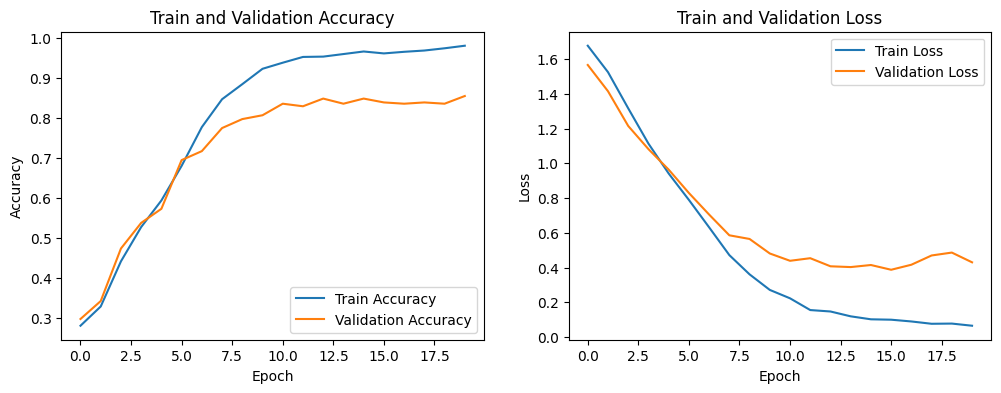

In [61]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Train and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Train and Validation Loss')

plt.show()

In [62]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred_classes)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.8363
Precision: 0.8394
Recall: 0.8363
F1 Score: 0.8326


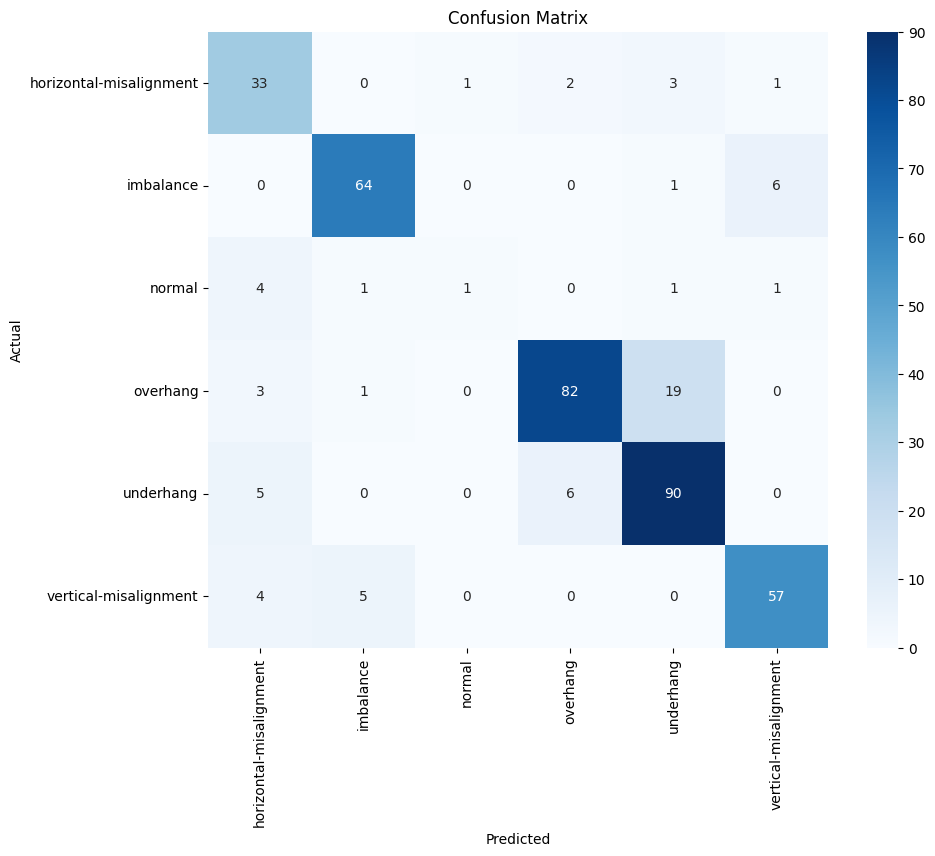

In [64]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()